In [53]:
import numpy as np
import matplotlib.pyplot as plt
import sys 
sys.path.append("/Users/pozzolabadmin/Documents/codebase/experiments/peptide_phase_mapping")
from utils import plot_phasemap

### Explanation

1. **Hilbert Space Approximation**: $ \mathcal{M} $ is approximated on a finite grid (e.g., $ t $ in $[0, 1]$).
2. **Finite Differences**: Gradients are computed using small perturbations ($ \epsilon $) along each dimension of $ \mathbb{R}^2 $. The $ L^2 $-norm ensures differences are measured consistently.
3. **Gradient Visualization**:
    - **Norm Visualization**: Shows how steep $ f $ is in $ \mathbb{R}^2 $.
    - **L2 Gradient**: Visualizes how $ f $ changes in $ \mathcal{M} $ along each input dimension.

---

### Mathematical Justification

1. **L2 Space Representation**: The discretized space $ t $ represents $ \mathcal{M} $. This is equivalent to projecting onto an orthonormal basis in $ \mathcal{M} $.
2. **Finite Differences**: Approximation of the derivative using:
   $$
   \frac{\partial f}{\partial x_i} \approx \frac{f(x + \epsilon e_i) - f(x)}{\epsilon},
   $$
   where $ e_i $ is the unit vector in the $ i $-th direction.
3. **Gradient Norm**: Norms in $ L^2 $ are computed as:
   $$
   \| \nabla f(x) \|_{L^2} = \sqrt{\int_{t} \left( \frac{\partial f}{\partial x_1} \right)^2 + \left( \frac{\partial f}{\partial x_2} \right)^2 \, dt}.
   $$


In [54]:
# Example Hilbert space: Functions in L2 norm approximated on a grid
def f(x):
    """
    Maps x in R^2 to a function in L2 space. The output is a discretized representation.
    Example: y(t) = sin(5t - norm(x)) over t ∈ [0, 1].
    """
    t = np.linspace(0, 1, 100)  # Discretized Hilbert space
    norm_x = np.linalg.norm(x, axis=1, keepdims=True)
    return np.sin(5 * t - norm_x)  # Example functional output

# Compute gradients using finite differences
def compute_gradient(x_samples, y_samples, epsilon=1e-2):
    """
    Approximates the gradient ∇f(x) using finite differences.
    :param x_samples: Input points in R^2 (n_samples, 2)
    :param y_samples: Corresponding outputs in L2 space (n_samples, n_discretized)
    :param epsilon: Small step for finite differences
    """
    gradients = []
    for i, x in enumerate(x_samples):
        grad = []
        for dim in range(x.shape[0]):  # Loop over dimensions of x
            x_forward = x.copy()
            x_forward[dim] += epsilon
            
            # Evaluate f at x and x_forward
            y_forward = f(x_forward[np.newaxis, :])[0]
            y = y_samples[i]
            
            # Compute gradient in the given dimension
            grad_dim = (y_forward - y) / epsilon
            grad.append(grad_dim)
        gradients.append(grad)
    return np.array(gradients)  # Shape: (n_samples, 2, n_discretized)



In [55]:
# Generate sparse samples in R^2
np.random.seed(42)
n_samples = 50
x_samples = np.random.rand(n_samples, 2) * 4 - 2  # Random points in [-2, 2]^2
y_samples = f(x_samples)  # Corresponding outputs in Hilbert space

# Compute gradients
gradients = compute_gradient(x_samples, y_samples)


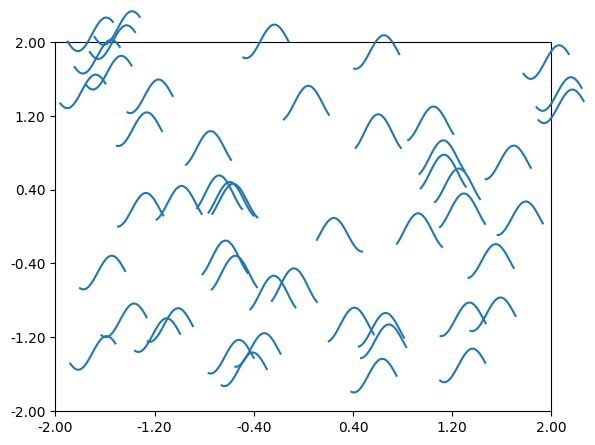

In [56]:
# Visualize function samples 

bounds = np.asarray([(-2.0, 2.0), (-2.0, 2.0)]).T 
fig, ax = plt.subplots()
plot_phasemap(bounds, ax, x_samples, y_samples)
plt.show()

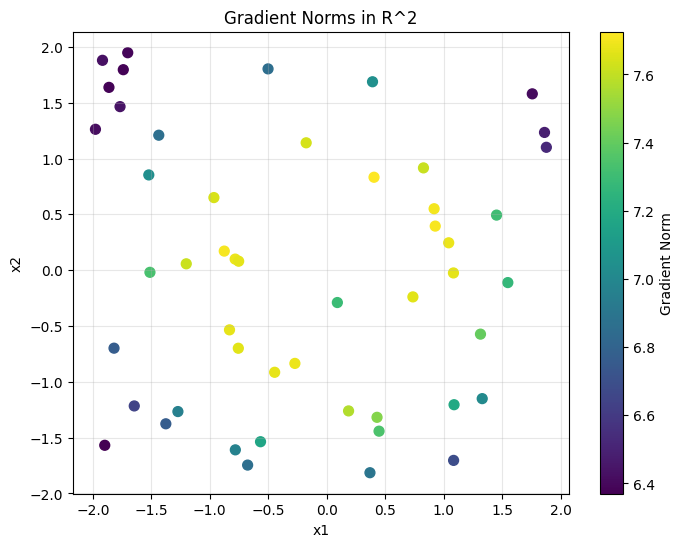

In [57]:
# Visualization
# 1. Visualize the norm of the gradient at each sampled point in R^2
grad_norms = np.linalg.norm(gradients, axis=(1, 2))  # Norm over L2 space and R^2

# Scatter plot of points colored by gradient norm
plt.figure(figsize=(8, 6))
plt.scatter(x_samples[:, 0], x_samples[:, 1], c=grad_norms, cmap="viridis", s=50)
plt.colorbar(label="Gradient Norm")
plt.title("Gradient Norms in R^2")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(alpha=0.3)


### 1. Using finite difference in Numpy

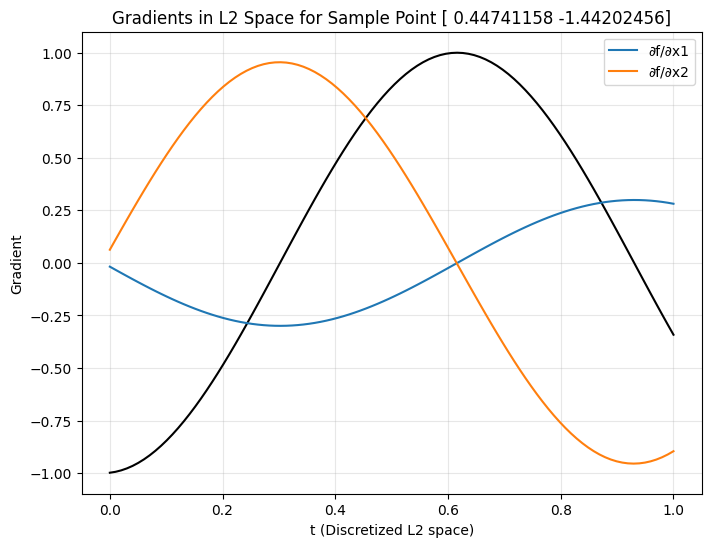

In [58]:
# 2. Visualize gradients in L2 space for one example
example_idx = 10
t = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 6))
plt.plot(t, y_samples[example_idx, :], color="k")
for dim, label in zip(range(2), ["x1", "x2"]):
    plt.plot(t, gradients[example_idx, dim], label=f"∂f/∂{label}")
plt.title(f"Gradients in L2 Space for Sample Point {x_samples[example_idx]}")
plt.xlabel("t (Discretized L2 space)")
plt.ylabel("Gradient")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

In [59]:
import torch 

def sine(x):
    """
    Maps x in R^2 to a function in L2 space. The output is a discretized representation.
    Example: y(t) = sin(5t - norm(x)) over t ∈ [0, 1].
    """
    t = torch.linspace(0, 1, 100)  # Discretized Hilbert space
    norm_x = torch.linalg.norm(x)
    return torch.sin(5 * t - norm_x)  # Example functional output



### 2. Using torch autograd

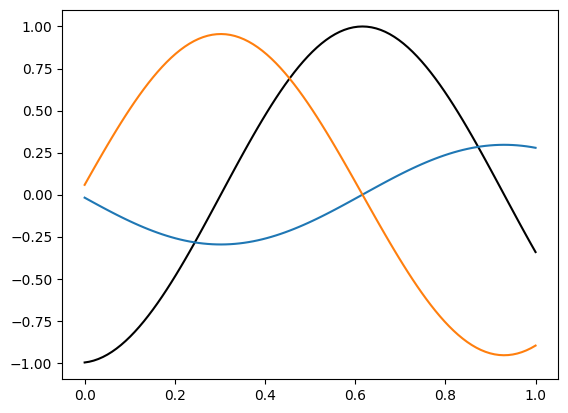

In [60]:
# Compute the gradient of y(t, x) with respect to x
xt = torch.tensor(x_samples[example_idx], requires_grad=True)
yt = sine(xt)
gradients = []
for i in range(len(t)):  # Loop over t to compute gradient for each sample
    yt[i].backward(retain_graph=True)  # Retain graph for multiple backward calls
    gradients.append(xt.grad.clone())  # Store the gradients
    xt.grad.zero_()  # Reset gradients for next computation

gradients = torch.stack(gradients)  # Stack gradients for all t

fig, ax = plt.subplots()
ax.plot(t, yt.detach().numpy(), color="k")
for dim, label in zip(range(2), ["x1", "x2"]):
    ax.plot(t, gradients[:, dim].detach().numpy(), label=f"∂f/∂{label}")
plt.show()

### 3. Using finite differences in PyTorch

In [ ]:
def compute_gradient(x_samples, y_samples, f, epsilon=1e-2):
    """
    Approximates the gradient ∇f(x) using finite differences in PyTorch.
    :param x_samples: Input points in R^2 (n_samples, 2) as a torch.Tensor.
    :param y_samples: Corresponding outputs in L2 space (n_samples, n_discretized) as a torch.Tensor.
    :param f: Function f(x) to compute the gradient.
    :param epsilon: Small step for finite differences.
    :return: Gradients of shape (n_samples, 2, n_discretized).
    """
    n_samples, n_dim = x_samples.shape
    _, n_discretized = y_samples.shape
    gradients = torch.zeros((n_samples, n_dim, n_discretized))  # Placeholder for gradients
    
    for i in range(n_samples):  # Loop over each sample
        for dim in range(n_dim):  # Loop over dimensions of x
            x_forward = x_samples[i].clone()
            x_forward[dim] += epsilon  # Step in the given dimension

            # Evaluate f at x and x_forward
            y_forward = f(x_forward) 

            # Compute gradient in the given dimension
            grad_dim = (y_forward - y_samples[i]) / epsilon
            gradients[i, dim, :] = grad_dim  # Store the gradient
        
    return gradients  # Shape: (n_samples, 2, n_discretized)

xt_samples = torch.tensor(x_samples, requires_grad=True)
yt_samples = torch.tensor(y_samples, requires_grad=True)
gradients = compute_gradient(xt_samples, yt_samples, sine)
print("Gradients shape:", gradients.shape)  # Should be (n_samples, 2, n_discretized)


torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

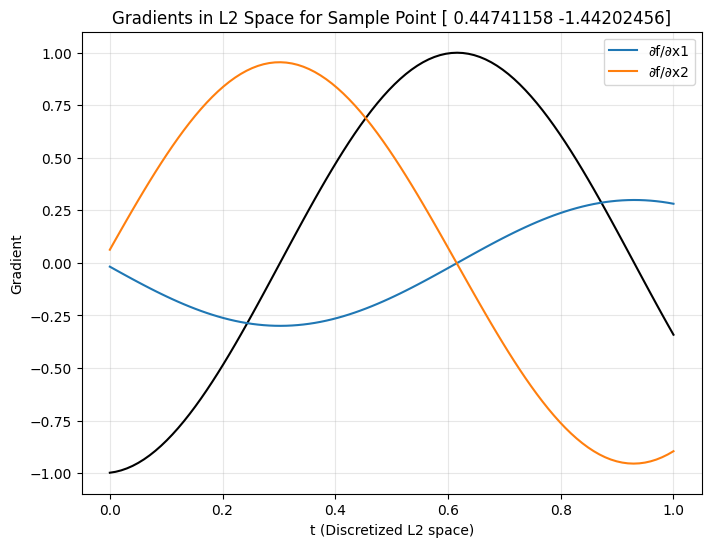

In [67]:
# 2. Visualize gradients in L2 space for one example
example_idx = 10
t = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 6))
plt.plot(t, yt_samples[example_idx,:].detach().numpy(), color="k")
for dim, label in zip(range(2), ["x1", "x2"]):
    plt.plot(t, gradients[example_idx, dim, : ].detach().numpy(), label=f"∂f/∂{label}")
plt.title(f"Gradients in L2 Space for Sample Point {xt_samples[example_idx].detach().numpy()}")
plt.xlabel("t (Discretized L2 space)")
plt.ylabel("Gradient")
plt.legend()
plt.grid(alpha=0.3)

plt.show()